## Project: Predict Bike Sharing Demand with AutoGluon

## Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [78]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [52]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [53]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "KAGGLE_USERNAME"
kaggle_key = "KAGGLE_KEY"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
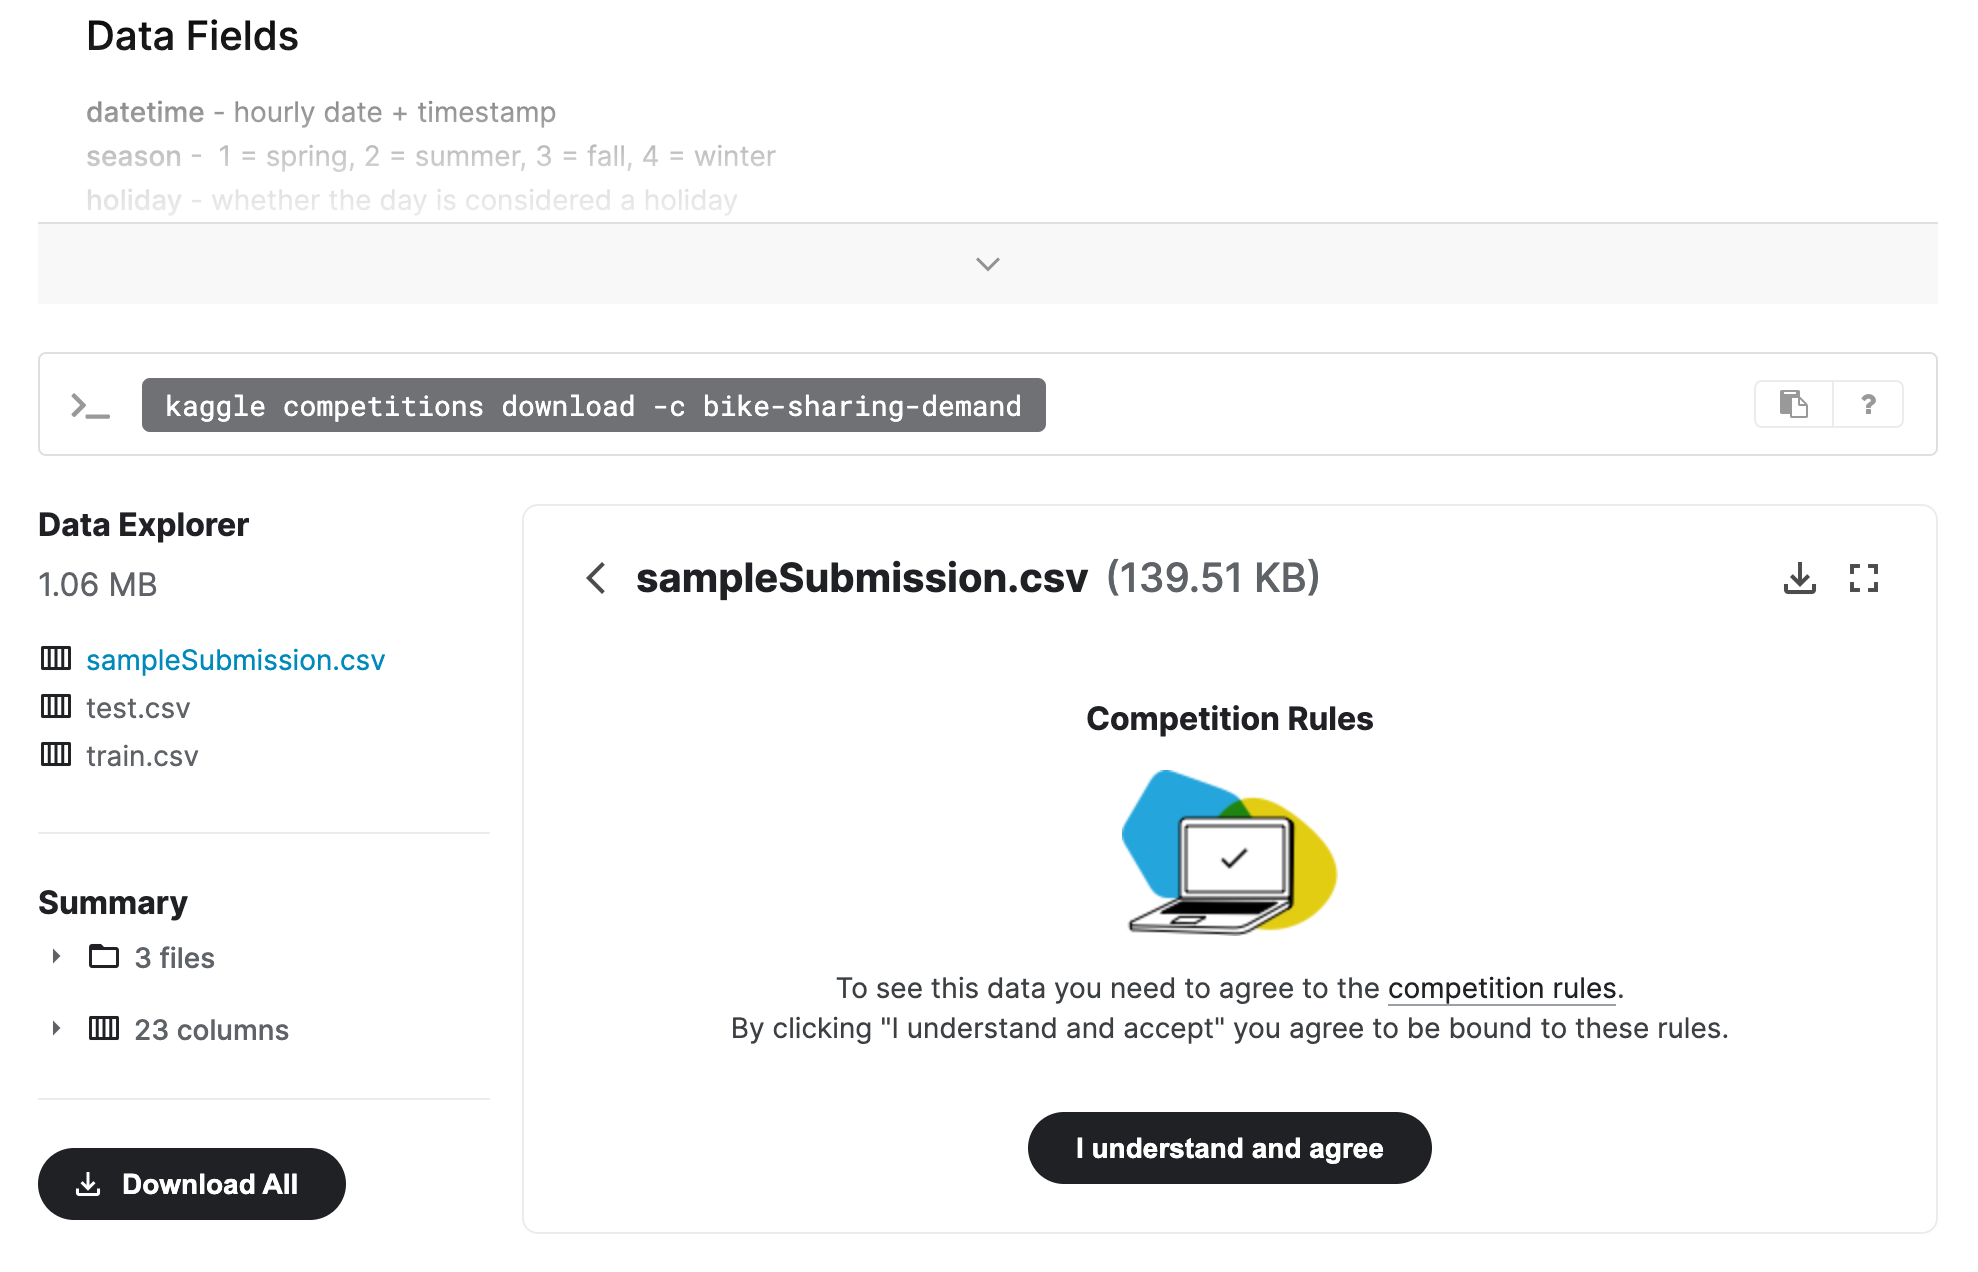

In [21]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [79]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [80]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [55]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [81]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [82]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [27]:
predictor = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(
    train_data=train.loc[:, ~train.columns.isin(['casual', 'registered'])],
    time_limit=600,
    presets='best_quality'
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220112_050054/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220112_050054/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2375.03 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column va

[1000]	train_set's rmse: 123.806	valid_set's rmse: 134.369
[2000]	train_set's rmse: 117.412	valid_set's rmse: 133.705


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 123.42	valid_set's rmse: 141.5


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 125.097	valid_set's rmse: 128.797
[2000]	train_set's rmse: 119.003	valid_set's rmse: 127.909
[3000]	train_set's rmse: 114.63	valid_set's rmse: 127.431
[4000]	train_set's rmse: 111.295	valid_set's rmse: 126.943
[5000]	train_set's rmse: 108.576	valid_set's rmse: 126.844
[6000]	train_set's rmse: 106.085	valid_set's rmse: 126.71


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.131	valid_set's rmse: 138.303
[2000]	train_set's rmse: 117.833	valid_set's rmse: 137.535


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.871	valid_set's rmse: 128.052
[2000]	train_set's rmse: 118.547	valid_set's rmse: 127.003
[3000]	train_set's rmse: 114.124	valid_set's rmse: 126.834
[4000]	train_set's rmse: 110.645	valid_set's rmse: 126.694


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.654	valid_set's rmse: 135.095
[2000]	train_set's rmse: 118.764	valid_set's rmse: 133.849
[3000]	train_set's rmse: 114.615	valid_set's rmse: 133.509
[4000]	train_set's rmse: 111.249	valid_set's rmse: 133.472
[5000]	train_set's rmse: 108.455	valid_set's rmse: 133.281


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.01	valid_set's rmse: 139.355
[2000]	train_set's rmse: 117.819	valid_set's rmse: 138.312
[3000]	train_set's rmse: 113.4	valid_set's rmse: 137.886
[4000]	train_set's rmse: 110.032	valid_set's rmse: 137.758


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.47	valid_set's rmse: 135.412


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.18	valid_set's rmse: 137.579
[2000]	train_set's rmse: 117.782	valid_set's rmse: 136.664
[3000]	train_set's rmse: 113.447	valid_set's rmse: 136.246
[4000]	train_set's rmse: 109.982	valid_set's rmse: 136.227


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.641	valid_set's rmse: 132.484


	-134.0883	 = Validation score   (root_mean_squared_error)
	52.2s	 = Training   runtime
	2.43s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 338.41s of the 538.46s of remaining time.
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argu

[1000]	train_set's rmse: 96.0217	valid_set's rmse: 123.249


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 94.7479	valid_set's rmse: 135.635


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.3055	valid_set's rmse: 132.087


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.1635	valid_set's rmse: 131.521


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-132.2864	 = Validation score   (root_mean_squared_error)
	18.6s	 = Training   runtime
	0.51s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 317.31s of the 517.36s of remaining time.
	-118.4567	 = Validation score   (root_mean_squared_error)
	6.94s	 = Training   runtime


### Review AutoGluon's training run with ranking of models that did the best.

In [28]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -115.078180      12.290289  499.118996                0.000644           0.371053            3       True         19
1   NeuralNetFastAI_BAG_L2 -115.635730      11.488951  463.387875                0.355994          95.421139            2       True         17
2        LightGBMXT_BAG_L2 -116.451721      11.385372  384.320977                0.252416          16.354240            2       True         12
3          CatBoost_BAG_L2 -116.585369      11.168369  394.376915                0.035412          26.410178            2       True         15
4          LightGBM_BAG_L2 -117.125217      11.219880  380.626123                0.086924          12.659387            2       True         13
5     ExtraTreesMSE_BAG_L2 -117.537966      11.594311  374.313177         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetMXNet_BAG_L1': 'StackerEnsembleModel_TabularNeuralNet',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGB

### Create predictions from test dataset

In [32]:
predictions = predictor.predict(test)
predictions.head()

0     96.763519
1     93.313057
2     93.314507
3    106.113068
4    106.117775
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [33]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      211.820679
std       128.545700
min        -4.357753
25%       107.593872
50%       196.471634
75%       296.787720
max       660.061096
Name: count, dtype: float64

In [38]:
# How many negative values do we have?
len(predictions[predictions < 0])

3

In [39]:
# Set them to zero
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [41]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [42]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 422kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [43]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2022-01-12 05:27:43  first raw submission  complete  1.39403      1.39403       


# Initial score of `1.39403`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

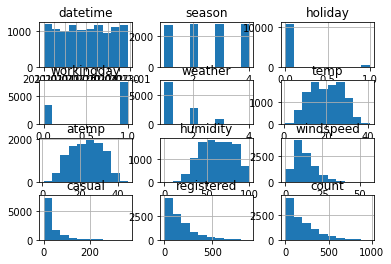

In [58]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [83]:
# create a new feature
train['hour'] = train.datetime.dt.hour
train['day'] = train.datetime.dt.day
train['month'] = train.datetime.dt.month
train.drop('datetime', axis=1, inplace=True)
test['hour'] = test.datetime.dt.hour
test['day'] = test.datetime.dt.day
test['month'] = test.datetime.dt.month
test.drop('datetime', axis=1, inplace=True)

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [84]:
train.loc[:, "season"] = train['season'].astype('category')
train.loc[:, "weather"] = train['weather'].astype('category')
test.loc[:, "season"] = test['season'].astype('category')
test.loc[:, "weather"] = test['weather'].astype('category')

In [85]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1


array([[<AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>],
       [<AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'month'}>]], dtype=object)

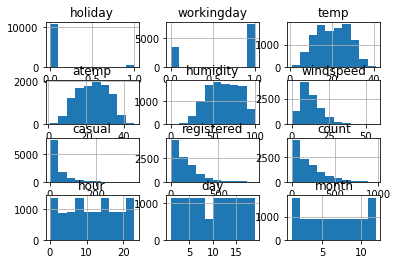

In [86]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [63]:
predictor_new_features = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(
    train_data=train.loc[:, ~train.columns.isin(['casual', 'registered'])],
    time_limit=600,
    presets='best_quality'
)   

No path specified. Models will be saved in: "AutogluonModels/ag-20220112_055659/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220112_055659/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 11
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1923.69 MB
	Train Data (Original)  Memory Usage: 0.81 MB (0.0% of available memory)
	Inferring data type of each feature based on column v

[1000]	train_set's rmse: 48.9044	valid_set's rmse: 58.5062
[2000]	train_set's rmse: 41.3506	valid_set's rmse: 55.2925
[3000]	train_set's rmse: 36.859	valid_set's rmse: 53.7647
[4000]	train_set's rmse: 33.6032	valid_set's rmse: 52.847
[5000]	train_set's rmse: 31.1554	valid_set's rmse: 52.2178
[6000]	train_set's rmse: 29.1287	valid_set's rmse: 51.86
[7000]	train_set's rmse: 27.4121	valid_set's rmse: 51.5546
[8000]	train_set's rmse: 25.9278	valid_set's rmse: 51.4031
[9000]	train_set's rmse: 24.6316	valid_set's rmse: 51.318
[10000]	train_set's rmse: 23.4921	valid_set's rmse: 51.2731


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 49.076	valid_set's rmse: 61.5283
[2000]	train_set's rmse: 41.65	valid_set's rmse: 57.0928
[3000]	train_set's rmse: 37.102	valid_set's rmse: 55.1783
[4000]	train_set's rmse: 33.8695	valid_set's rmse: 53.9665
[5000]	train_set's rmse: 31.4721	valid_set's rmse: 53.3942
[6000]	train_set's rmse: 29.4826	valid_set's rmse: 52.9293
[7000]	train_set's rmse: 27.764	valid_set's rmse: 52.5594
[8000]	train_set's rmse: 26.286	valid_set's rmse: 52.2535
[9000]	train_set's rmse: 24.971	valid_set's rmse: 52.0743
[10000]	train_set's rmse: 23.7843	valid_set's rmse: 51.8779


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 49.3605	valid_set's rmse: 57.9867
[2000]	train_set's rmse: 41.7928	valid_set's rmse: 55.3314
[3000]	train_set's rmse: 37.2396	valid_set's rmse: 54.0667
[4000]	train_set's rmse: 34.1549	valid_set's rmse: 53.2578
[5000]	train_set's rmse: 31.7023	valid_set's rmse: 52.6761
[6000]	train_set's rmse: 29.6814	valid_set's rmse: 52.2346
[7000]	train_set's rmse: 28.0041	valid_set's rmse: 52.0458
[8000]	train_set's rmse: 26.52	valid_set's rmse: 51.798
[9000]	train_set's rmse: 25.2438	valid_set's rmse: 51.6011
[10000]	train_set's rmse: 24.0943	valid_set's rmse: 51.4968


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 48.8076	valid_set's rmse: 65.3452
[2000]	train_set's rmse: 41.2579	valid_set's rmse: 61.5786
[3000]	train_set's rmse: 36.8	valid_set's rmse: 59.5796
[4000]	train_set's rmse: 33.6235	valid_set's rmse: 58.3909
[5000]	train_set's rmse: 31.1005	valid_set's rmse: 57.5394
[6000]	train_set's rmse: 29.0853	valid_set's rmse: 56.9379
[7000]	train_set's rmse: 27.4081	valid_set's rmse: 56.525
[8000]	train_set's rmse: 25.9262	valid_set's rmse: 56.1288
[9000]	train_set's rmse: 24.6633	valid_set's rmse: 55.8774
[10000]	train_set's rmse: 23.5406	valid_set's rmse: 55.6773


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 49.5446	valid_set's rmse: 57.1767
[2000]	train_set's rmse: 41.7965	valid_set's rmse: 54.1505
[3000]	train_set's rmse: 37.3078	valid_set's rmse: 52.7393
[4000]	train_set's rmse: 34.1296	valid_set's rmse: 51.8955
[5000]	train_set's rmse: 31.6612	valid_set's rmse: 51.2614
[6000]	train_set's rmse: 29.6607	valid_set's rmse: 50.8592
[7000]	train_set's rmse: 27.978	valid_set's rmse: 50.5376
[8000]	train_set's rmse: 26.498	valid_set's rmse: 50.2821
[9000]	train_set's rmse: 25.2442	valid_set's rmse: 50.1288
[10000]	train_set's rmse: 24.1079	valid_set's rmse: 50.0295


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 48.9939	valid_set's rmse: 62.2439
[2000]	train_set's rmse: 41.2357	valid_set's rmse: 59.3721
[3000]	train_set's rmse: 36.71	valid_set's rmse: 58.0591
[4000]	train_set's rmse: 33.516	valid_set's rmse: 57.3296
[5000]	train_set's rmse: 31.1209	valid_set's rmse: 56.8391
[6000]	train_set's rmse: 29.0925	valid_set's rmse: 56.5041
[7000]	train_set's rmse: 27.4476	valid_set's rmse: 56.33
[8000]	train_set's rmse: 25.9711	valid_set's rmse: 56.1373
[9000]	train_set's rmse: 24.6845	valid_set's rmse: 56.01
[10000]	train_set's rmse: 23.5475	valid_set's rmse: 55.945


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 49.4523	valid_set's rmse: 59.7637
[2000]	train_set's rmse: 41.9033	valid_set's rmse: 55.5804
[3000]	train_set's rmse: 37.4716	valid_set's rmse: 53.8728
[4000]	train_set's rmse: 34.2018	valid_set's rmse: 52.8468
[5000]	train_set's rmse: 31.656	valid_set's rmse: 52.2064
[6000]	train_set's rmse: 29.5762	valid_set's rmse: 51.8682
[7000]	train_set's rmse: 27.8415	valid_set's rmse: 51.626
[8000]	train_set's rmse: 26.2925	valid_set's rmse: 51.4244
[9000]	train_set's rmse: 24.9907	valid_set's rmse: 51.2622
[10000]	train_set's rmse: 23.8126	valid_set's rmse: 51.1971


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 49.3178	valid_set's rmse: 61.8269
[2000]	train_set's rmse: 41.6386	valid_set's rmse: 58.4412
[3000]	train_set's rmse: 37.2481	valid_set's rmse: 56.9088
[4000]	train_set's rmse: 34.0489	valid_set's rmse: 55.9831
[5000]	train_set's rmse: 31.5287	valid_set's rmse: 55.2498
[6000]	train_set's rmse: 29.471	valid_set's rmse: 54.5829
[7000]	train_set's rmse: 27.7202	valid_set's rmse: 54.2989
[8000]	train_set's rmse: 26.2293	valid_set's rmse: 53.9764
[9000]	train_set's rmse: 24.9505	valid_set's rmse: 53.712
[10000]	train_set's rmse: 23.8083	valid_set's rmse: 53.4973


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 48.8209	valid_set's rmse: 59.6892
[2000]	train_set's rmse: 41.1381	valid_set's rmse: 57.1399
[3000]	train_set's rmse: 36.7199	valid_set's rmse: 55.8847
[4000]	train_set's rmse: 33.5767	valid_set's rmse: 55.1717
[5000]	train_set's rmse: 31.1023	valid_set's rmse: 54.6279
[6000]	train_set's rmse: 29.1048	valid_set's rmse: 54.1752
[7000]	train_set's rmse: 27.4092	valid_set's rmse: 53.9394
[8000]	train_set's rmse: 25.978	valid_set's rmse: 53.7219
[9000]	train_set's rmse: 24.6942	valid_set's rmse: 53.528
[10000]	train_set's rmse: 23.5357	valid_set's rmse: 53.4824


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 49.9083	valid_set's rmse: 56.2102
[2000]	train_set's rmse: 42.101	valid_set's rmse: 53.324
[3000]	train_set's rmse: 37.6069	valid_set's rmse: 51.772
[4000]	train_set's rmse: 34.4141	valid_set's rmse: 50.7136
[5000]	train_set's rmse: 31.9408	valid_set's rmse: 50.1177
[6000]	train_set's rmse: 29.868	valid_set's rmse: 49.6156
[7000]	train_set's rmse: 28.1437	valid_set's rmse: 49.2995
[8000]	train_set's rmse: 26.6001	valid_set's rmse: 49.0901
[9000]	train_set's rmse: 25.3058	valid_set's rmse: 48.9468
[10000]	train_set's rmse: 24.1666	valid_set's rmse: 48.8306


	-52.3719	 = Validation score   (root_mean_squared_error)
	142.86s	 = Training   runtime
	9.23s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 228.58s of the 428.63s of remaining time.
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.3592	valid_set's rmse: 52.5918
[2000]	train_set's rmse: 23.759	valid_set's rmse: 50.5573
[3000]	train_set's rmse: 18.5382	valid_set's rmse: 50.0138
[4000]	train_set's rmse: 15.0877	valid_set's rmse: 49.9663


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.0751	valid_set's rmse: 54.5715
[2000]	train_set's rmse: 23.9171	valid_set's rmse: 52.2193
[3000]	train_set's rmse: 18.9315	valid_set's rmse: 51.3141
[4000]	train_set's rmse: 15.467	valid_set's rmse: 50.8911
[5000]	train_set's rmse: 12.7863	valid_set's rmse: 50.818
[6000]	train_set's rmse: 10.8191	valid_set's rmse: 50.8082


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.3105	valid_set's rmse: 53.1549
[2000]	train_set's rmse: 24.2697	valid_set's rmse: 51.2275
[3000]	train_set's rmse: 19.401	valid_set's rmse: 50.4764
[4000]	train_set's rmse: 15.7236	valid_set's rmse: 50.3236
[5000]	train_set's rmse: 12.8988	valid_set's rmse: 50.3997


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 32.5463	valid_set's rmse: 60.1829
[2000]	train_set's rmse: 23.4948	valid_set's rmse: 57.9184
[3000]	train_set's rmse: 18.2966	valid_set's rmse: 57.4338
[4000]	train_set's rmse: 14.9832	valid_set's rmse: 56.9543
[5000]	train_set's rmse: 12.5574	valid_set's rmse: 56.8715
[6000]	train_set's rmse: 10.6433	valid_set's rmse: 56.7687
[7000]	train_set's rmse: 9.22102	valid_set's rmse: 56.6909
[8000]	train_set's rmse: 7.96365	valid_set's rmse: 56.6698
[9000]	train_set's rmse: 6.94366	valid_set's rmse: 56.7068


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.4723	valid_set's rmse: 53.5351
[2000]	train_set's rmse: 24.2422	valid_set's rmse: 51.9254
[3000]	train_set's rmse: 19.1923	valid_set's rmse: 51.4401
[4000]	train_set's rmse: 15.6558	valid_set's rmse: 51.1402
[5000]	train_set's rmse: 13.0853	valid_set's rmse: 50.9956
[6000]	train_set's rmse: 11.1529	valid_set's rmse: 51.017


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.0582	valid_set's rmse: 59.0037
[2000]	train_set's rmse: 23.9462	valid_set's rmse: 57.1527
[3000]	train_set's rmse: 18.8212	valid_set's rmse: 56.5909
[4000]	train_set's rmse: 15.3654	valid_set's rmse: 56.1695


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.1019	valid_set's rmse: 56.3277
[2000]	train_set's rmse: 23.8424	valid_set's rmse: 54.9066
[3000]	train_set's rmse: 18.9649	valid_set's rmse: 54.7537
[4000]	train_set's rmse: 15.2679	valid_set's rmse: 54.8261


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 32.796	valid_set's rmse: 54.666
[2000]	train_set's rmse: 24.2556	valid_set's rmse: 52.5589
[3000]	train_set's rmse: 18.9353	valid_set's rmse: 51.6378
[4000]	train_set's rmse: 15.4278	valid_set's rmse: 51.3155
[5000]	train_set's rmse: 12.848	valid_set's rmse: 51.1867
[6000]	train_set's rmse: 10.8293	valid_set's rmse: 50.9674
[7000]	train_set's rmse: 9.3828	valid_set's rmse: 50.8947
[8000]	train_set's rmse: 8.20521	valid_set's rmse: 50.8313
[9000]	train_set's rmse: 7.13663	valid_set's rmse: 50.8066
[10000]	train_set's rmse: 6.31845	valid_set's rmse: 50.854


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 32.9084	valid_set's rmse: 56.8177
[2000]	train_set's rmse: 24.0182	valid_set's rmse: 54.7819
[3000]	train_set's rmse: 18.7338	valid_set's rmse: 54.2045
[4000]	train_set's rmse: 15.1193	valid_set's rmse: 54.0339


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.094	valid_set's rmse: 51.5457
[2000]	train_set's rmse: 24.2495	valid_set's rmse: 49.9594
[3000]	train_set's rmse: 19.1972	valid_set's rmse: 49.5207


	-52.4215	 = Validation score   (root_mean_squared_error)
	78.65s	 = Training   runtime
	3.18s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 137.51s of the 337.57s of remaining time.
	-64.1606	 = Validation score   (root_mean_squared_error)
	7.64s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 127.1s of the 327.15s of remaining time.
	Time limit exceeded... Skipping CatBoost_BAG_L1.
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 111.54s of the 311.59s of remaining time.
	-64.0834	 = Validation score   (root_mean_squared_error)
	3.54s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 105.03s of the 305.09s of remaining time.
	Ran out of time, stopping training early. (Stopping on epoch 18)
	Ran out of time, stopping training early. (Stopping on epoch 18)
	Ran out of time, stopping training early. 

In [64]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -49.030758      15.367342  491.839526                0.000763           0.329966            3       True         15
1          CatBoost_BAG_L2  -49.607807      14.064175  382.167771                0.063165          50.515833            2       True         12
2     ExtraTreesMSE_BAG_L2  -49.790899      14.464101  337.599297                0.463092           5.947360            2       True         13
3   RandomForestMSE_BAG_L2  -50.003947      14.462690  353.431949                0.461680          21.780012            2       True         11
4   NeuralNetFastAI_BAG_L2  -50.243181      14.378642  413.266355                0.377633          81.614417            2       True         14
5          LightGBM_BAG_L2  -50.298385      14.096332  343.401747         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -123.92263994015985,
  'KNeighborsDist_BAG_L1': -119.37339448003198,
  'LightGBMXT_BAG_L1': -52.3718918772298,
  'LightG

In [74]:
predictions_new_features = predictor_new_features.predict(test)
# Remember to set all negative values to zero
predictions_new_features[predictions_new_features < 0] = 0

In [72]:
# Same submitting predictions
submission["count"] = predictions_new_features
submission.to_csv("submission_new_features.csv", index=False)

In [73]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 493kB/s]
Successfully submitted to Bike Sharing Demand

In [75]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2022-01-12 06:15:47  new features          complete  0.55592      0.55592       
submission.csv               2022-01-12 05:27:43  first raw submission  complete  1.39403      1.39403       


#### New Score of `0.55592`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [87]:
predictor_new_hpo = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(
  train_data=train.loc[:, ~train.columns.isin(['casual', 'registered'])],
    time_limit=600,
    presets='best_quality',
#     hyperparameters={},
    hyperparameter_tune_kwargs='random'
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220112_083902/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220112_083902/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 11
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1830.22 MB
	Train Data (Original)  Memory Usage: 0.81 MB (0.0% of available memory)
	Inferring data type of each feature based on column v

[1000]	train_set's rmse: 49.304	valid_set's rmse: 58.8439


	Ran out of time, early stopping on iteration 1371. Best iteration is:
	[1371]	train_set's rmse: 45.6842	valid_set's rmse: 56.9849
	Time limit exceeded
Fitted model: LightGBMXT_BAG_L1/T0 ...
	-56.9849	 = Validation score   (root_mean_squared_error)
	2.77s	 = Training   runtime
	0.11s	 = Validation runtime
Hyperparameter tuning model: LightGBM_BAG_L1 ...
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.3592	valid_set's rmse: 52.5918


	Ran out of time, early stopping on iteration 1667. Best iteration is:
	[1665]	train_set's rmse: 26.2842	valid_set's rmse: 50.9224
	Time limit exceeded
Fitted model: LightGBM_BAG_L1/T0 ...
	-50.9224	 = Validation score   (root_mean_squared_error)
	2.83s	 = Training   runtime
	0.11s	 = Validation runtime
Hyperparameter tuning model: RandomForestMSE_BAG_L1 ...
Fitted model: RandomForestMSE_BAG_L1/T0 ...
	-64.1606	 = Validation score   (root_mean_squared_error)
	7.74s	 = Training   runtime
	0.43s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ...
	Time limit exceeded
Fitted model: CatBoost_BAG_L1/T0 ...
	-63.3049	 = Validation score   (root_mean_squared_error)
	3.76s	 = Training   runtime
	0.01s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesMSE_BAG_L1 ...
Fitted model: ExtraTreesMSE_BAG_L1/T0 ...
	-64.0834	 = Validation score   (root_mean_squared_error)
	3.64s	 = Training   runtime
	0.45s	 = Validation runtime
Hyperparameter tuning model: NeuralNetFastAI

[1000]	train_set's rmse: 49.076	valid_set's rmse: 61.5283
[2000]	train_set's rmse: 41.65	valid_set's rmse: 57.0928
[3000]	train_set's rmse: 37.102	valid_set's rmse: 55.1783
[4000]	train_set's rmse: 33.8695	valid_set's rmse: 53.9665
[5000]	train_set's rmse: 31.4721	valid_set's rmse: 53.3942
[6000]	train_set's rmse: 29.4826	valid_set's rmse: 52.9293
[7000]	train_set's rmse: 27.764	valid_set's rmse: 52.5594
[8000]	train_set's rmse: 26.286	valid_set's rmse: 52.2535
[9000]	train_set's rmse: 24.971	valid_set's rmse: 52.0743
[10000]	train_set's rmse: 23.7843	valid_set's rmse: 51.8779


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 49.3605	valid_set's rmse: 57.9867
[2000]	train_set's rmse: 41.7928	valid_set's rmse: 55.3314
[3000]	train_set's rmse: 37.2396	valid_set's rmse: 54.0667
[4000]	train_set's rmse: 34.1549	valid_set's rmse: 53.2578
[5000]	train_set's rmse: 31.7023	valid_set's rmse: 52.6761
[6000]	train_set's rmse: 29.6814	valid_set's rmse: 52.2346
[7000]	train_set's rmse: 28.0041	valid_set's rmse: 52.0458
[8000]	train_set's rmse: 26.52	valid_set's rmse: 51.798
[9000]	train_set's rmse: 25.2438	valid_set's rmse: 51.6011
[10000]	train_set's rmse: 24.0943	valid_set's rmse: 51.4968


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 48.8076	valid_set's rmse: 65.3452
[2000]	train_set's rmse: 41.2579	valid_set's rmse: 61.5786
[3000]	train_set's rmse: 36.8	valid_set's rmse: 59.5796
[4000]	train_set's rmse: 33.6235	valid_set's rmse: 58.3909
[5000]	train_set's rmse: 31.1005	valid_set's rmse: 57.5394
[6000]	train_set's rmse: 29.0853	valid_set's rmse: 56.9379
[7000]	train_set's rmse: 27.4081	valid_set's rmse: 56.525
[8000]	train_set's rmse: 25.9262	valid_set's rmse: 56.1288
[9000]	train_set's rmse: 24.6633	valid_set's rmse: 55.8774
[10000]	train_set's rmse: 23.5406	valid_set's rmse: 55.6773


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 49.5446	valid_set's rmse: 57.1767
[2000]	train_set's rmse: 41.7965	valid_set's rmse: 54.1505
[3000]	train_set's rmse: 37.3078	valid_set's rmse: 52.7393
[4000]	train_set's rmse: 34.1296	valid_set's rmse: 51.8955
[5000]	train_set's rmse: 31.6612	valid_set's rmse: 51.2614
[6000]	train_set's rmse: 29.6607	valid_set's rmse: 50.8592
[7000]	train_set's rmse: 27.978	valid_set's rmse: 50.5376
[8000]	train_set's rmse: 26.498	valid_set's rmse: 50.2821
[9000]	train_set's rmse: 25.2442	valid_set's rmse: 50.1288
[10000]	train_set's rmse: 24.1079	valid_set's rmse: 50.0295


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 48.9939	valid_set's rmse: 62.2439
[2000]	train_set's rmse: 41.2357	valid_set's rmse: 59.3721
[3000]	train_set's rmse: 36.71	valid_set's rmse: 58.0591
[4000]	train_set's rmse: 33.516	valid_set's rmse: 57.3296
[5000]	train_set's rmse: 31.1209	valid_set's rmse: 56.8391
[6000]	train_set's rmse: 29.0925	valid_set's rmse: 56.5041
[7000]	train_set's rmse: 27.4476	valid_set's rmse: 56.33
[8000]	train_set's rmse: 25.9711	valid_set's rmse: 56.1373
[9000]	train_set's rmse: 24.6845	valid_set's rmse: 56.01
[10000]	train_set's rmse: 23.5475	valid_set's rmse: 55.945


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 49.4523	valid_set's rmse: 59.7637
[2000]	train_set's rmse: 41.9033	valid_set's rmse: 55.5804
[3000]	train_set's rmse: 37.4716	valid_set's rmse: 53.8728
[4000]	train_set's rmse: 34.2018	valid_set's rmse: 52.8468
[5000]	train_set's rmse: 31.656	valid_set's rmse: 52.2064
[6000]	train_set's rmse: 29.5762	valid_set's rmse: 51.8682
[7000]	train_set's rmse: 27.8415	valid_set's rmse: 51.626
[8000]	train_set's rmse: 26.2925	valid_set's rmse: 51.4244
[9000]	train_set's rmse: 24.9907	valid_set's rmse: 51.2622
[10000]	train_set's rmse: 23.8126	valid_set's rmse: 51.1971


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 49.3178	valid_set's rmse: 61.8269
[2000]	train_set's rmse: 41.6386	valid_set's rmse: 58.4412
[3000]	train_set's rmse: 37.2481	valid_set's rmse: 56.9088
[4000]	train_set's rmse: 34.0489	valid_set's rmse: 55.9831
[5000]	train_set's rmse: 31.5287	valid_set's rmse: 55.2498
[6000]	train_set's rmse: 29.471	valid_set's rmse: 54.5829
[7000]	train_set's rmse: 27.7202	valid_set's rmse: 54.2989
[8000]	train_set's rmse: 26.2293	valid_set's rmse: 53.9764
[9000]	train_set's rmse: 24.9505	valid_set's rmse: 53.712
[10000]	train_set's rmse: 23.8083	valid_set's rmse: 53.4973


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 48.8209	valid_set's rmse: 59.6892
[2000]	train_set's rmse: 41.1381	valid_set's rmse: 57.1399
[3000]	train_set's rmse: 36.7199	valid_set's rmse: 55.8847
[4000]	train_set's rmse: 33.5767	valid_set's rmse: 55.1717
[5000]	train_set's rmse: 31.1023	valid_set's rmse: 54.6279
[6000]	train_set's rmse: 29.1048	valid_set's rmse: 54.1752
[7000]	train_set's rmse: 27.4092	valid_set's rmse: 53.9394
[8000]	train_set's rmse: 25.978	valid_set's rmse: 53.7219
[9000]	train_set's rmse: 24.6942	valid_set's rmse: 53.528
[10000]	train_set's rmse: 23.5357	valid_set's rmse: 53.4824


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 49.9083	valid_set's rmse: 56.2102
[2000]	train_set's rmse: 42.101	valid_set's rmse: 53.324
[3000]	train_set's rmse: 37.6069	valid_set's rmse: 51.772
[4000]	train_set's rmse: 34.4141	valid_set's rmse: 50.7136
[5000]	train_set's rmse: 31.9408	valid_set's rmse: 50.1177
[6000]	train_set's rmse: 29.868	valid_set's rmse: 49.6156
[7000]	train_set's rmse: 28.1437	valid_set's rmse: 49.2995
[8000]	train_set's rmse: 26.6001	valid_set's rmse: 49.0901
[9000]	train_set's rmse: 25.3058	valid_set's rmse: 48.9468
[10000]	train_set's rmse: 24.1666	valid_set's rmse: 48.8306


	-52.9602	 = Validation score   (root_mean_squared_error)
	132.6s	 = Training   runtime
	9.13s	 = Validation runtime
Fitting model: LightGBM_BAG_L1/T0 ... Training model for up to 191.72s of the 391.77s of remaining time.
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.0751	valid_set's rmse: 54.5715
[2000]	train_set's rmse: 23.9171	valid_set's rmse: 52.2193
[3000]	train_set's rmse: 18.9315	valid_set's rmse: 51.3141
[4000]	train_set's rmse: 15.467	valid_set's rmse: 50.8911
[5000]	train_set's rmse: 12.7863	valid_set's rmse: 50.818
[6000]	train_set's rmse: 10.8191	valid_set's rmse: 50.8082


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.3105	valid_set's rmse: 53.1549
[2000]	train_set's rmse: 24.2697	valid_set's rmse: 51.2275
[3000]	train_set's rmse: 19.401	valid_set's rmse: 50.4764
[4000]	train_set's rmse: 15.7236	valid_set's rmse: 50.3236
[5000]	train_set's rmse: 12.8988	valid_set's rmse: 50.3997


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 32.5463	valid_set's rmse: 60.1829
[2000]	train_set's rmse: 23.4948	valid_set's rmse: 57.9184
[3000]	train_set's rmse: 18.2966	valid_set's rmse: 57.4338
[4000]	train_set's rmse: 14.9832	valid_set's rmse: 56.9543
[5000]	train_set's rmse: 12.5574	valid_set's rmse: 56.8715
[6000]	train_set's rmse: 10.6433	valid_set's rmse: 56.7687
[7000]	train_set's rmse: 9.22102	valid_set's rmse: 56.6909
[8000]	train_set's rmse: 7.96365	valid_set's rmse: 56.6698
[9000]	train_set's rmse: 6.94366	valid_set's rmse: 56.7068


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.4723	valid_set's rmse: 53.5351
[2000]	train_set's rmse: 24.2422	valid_set's rmse: 51.9254
[3000]	train_set's rmse: 19.1923	valid_set's rmse: 51.4401
[4000]	train_set's rmse: 15.6558	valid_set's rmse: 51.1402
[5000]	train_set's rmse: 13.0853	valid_set's rmse: 50.9956
[6000]	train_set's rmse: 11.1529	valid_set's rmse: 51.017


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.0582	valid_set's rmse: 59.0037
[2000]	train_set's rmse: 23.9462	valid_set's rmse: 57.1527
[3000]	train_set's rmse: 18.8212	valid_set's rmse: 56.5909
[4000]	train_set's rmse: 15.3654	valid_set's rmse: 56.1695


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.1019	valid_set's rmse: 56.3277
[2000]	train_set's rmse: 23.8424	valid_set's rmse: 54.9066
[3000]	train_set's rmse: 18.9649	valid_set's rmse: 54.7537
[4000]	train_set's rmse: 15.2679	valid_set's rmse: 54.8261


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 32.796	valid_set's rmse: 54.666
[2000]	train_set's rmse: 24.2556	valid_set's rmse: 52.5589
[3000]	train_set's rmse: 18.9353	valid_set's rmse: 51.6378
[4000]	train_set's rmse: 15.4278	valid_set's rmse: 51.3155
[5000]	train_set's rmse: 12.848	valid_set's rmse: 51.1867
[6000]	train_set's rmse: 10.8293	valid_set's rmse: 50.9674
[7000]	train_set's rmse: 9.3828	valid_set's rmse: 50.8947
[8000]	train_set's rmse: 8.20521	valid_set's rmse: 50.8313
[9000]	train_set's rmse: 7.13663	valid_set's rmse: 50.8066
[10000]	train_set's rmse: 6.31845	valid_set's rmse: 50.854


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 32.9084	valid_set's rmse: 56.8177
[2000]	train_set's rmse: 24.0182	valid_set's rmse: 54.7819
[3000]	train_set's rmse: 18.7338	valid_set's rmse: 54.2045
[4000]	train_set's rmse: 15.1193	valid_set's rmse: 54.0339


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 33.094	valid_set's rmse: 51.5457
[2000]	train_set's rmse: 24.2495	valid_set's rmse: 49.9594
[3000]	train_set's rmse: 19.1972	valid_set's rmse: 49.5207


	-52.5193	 = Validation score   (root_mean_squared_error)
	74.87s	 = Training   runtime
	3.24s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1/T0 ... Training model for up to 107.97s of the 308.01s of remaining time.
	-64.1606	 = Validation score   (root_mean_squared_error)
	7.74s	 = Training   runtime
	0.43s	 = Validation runtime
Fitting model: CatBoost_BAG_L1/T0 ... Training model for up to 107.89s of the 307.93s of remaining time.
	Time limit exceeded... Skipping CatBoost_BAG_L1/T0.
Fitting model: ExtraTreesMSE_BAG_L1/T0 ... Training model for up to 92.52s of the 292.57s of remaining time.
	-64.0834	 = Validation score   (root_mean_squared_error)
	3.64s	 = Training   runtime
	0.45s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1/T0 ... Training model for up to 92.45s of the 292.49s of remaining time.
	Ran out of time, stopping training early. (Stopping on epoch 17)
	Ran out of time, stopping training early. (Stopping on epoch 18)
	Ran out of time, stopping tr

In [88]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                        model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L3  -49.567860      15.396603  453.147833                0.000789           0.328053            3       True         20
1          CatBoost_BAG_L2/T0  -50.168368      14.094269  350.212256                0.066942          42.204177            2       True         15
2   RandomForestMSE_BAG_L2/T0  -50.247969      14.492765  329.880038                0.465439          21.871958            2       True         14
3     ExtraTreesMSE_BAG_L2/T0  -50.266710      14.489806  313.949584                0.462479           5.941505            2       True         16
4          LightGBM_BAG_L2/T0  -50.591998      14.123194  319.935438                0.095868          11.927358            2       True         13
5           XGBoost_BAG_L2/T0  -50.732498      14.037074

{'model_types': {'KNeighborsUnif_BAG_L1/T0': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1/T0': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1/T0': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T0': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1/T0': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1/T0': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1/T0': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1/T0': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1/T0': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2/T0': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T0': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2/T0': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2/T0': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2/T0': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2/T0': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG

In [89]:
predictions_new_hpo = predictor_new_hpo.predict(test)
# Remember to set all negative values to zero
predictions_new_hpo[predictions_new_hpo < 0] = 0

In [90]:
# Same submitting predictions
submission["count"] = predictions_new_hpo
submission.to_csv("submission_new_hpo.csv", index=False)

In [91]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 476kB/s]
Successfully submitted to Bike Sharing Demand

In [92]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-01-12 08:51:51  new features with hyperparameters  complete  0.54368      0.54368       
submission_new_features.csv  2022-01-12 06:15:47  new features                       complete  0.55592      0.55592       
submission.csv               2022-01-12 05:27:43  first raw submission               complete  1.39403      1.39403       


#### New Score of `0.54368`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

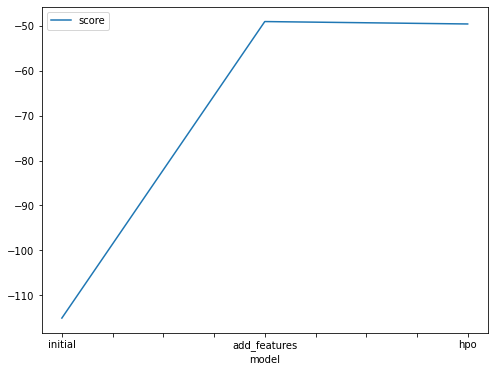

In [95]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-115.078180, -49.030758,-49.567860]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

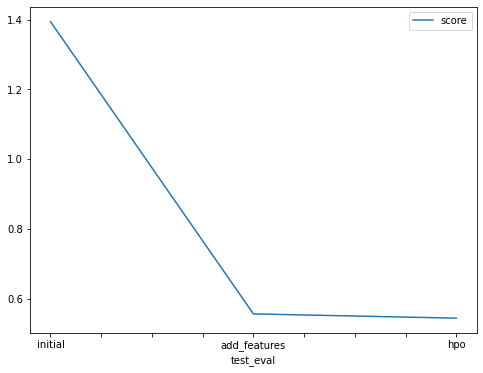

In [94]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.39403, 0.55592, 0.54368]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [96]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['bayesopt', 'bayesopt', 'random'],
    "score": [1.39403, 0.55592, 0.54368]
})

,model,hpo1,score
0,initial,bayesopt,1.39403
1,add_features,bayesopt,0.55592
2,hpo,random,0.54368
